## About Dataset

### Content

Dataset is organized into 2 folders (train, test) and both train and test contain 3 subfolders (COVID19, PNEUMONIA, NORMAL). DataSet contains total 6432 x-ray images and test data have 20% of total images.

#### Acknowledgements

Images are collected from various publicly available resources. If you use the data for research please give credit to authors:

Sources:

https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia

https://github.com/ieee8023/covid-chestxray-dataset

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

https://github.com/agchung

#### Inspiration

Application of Artificial Intelligence (AI) techniques with radiological images for COVID-19 diagnosis.

### Importing libraries that are required to build this project

In [1]:
import matplotlib.pyplot as plt
import keras
import numpy as np
import os
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.applications import *
import time
from tensorflow.keras.callbacks import TensorBoard
from sklearn.utils import class_weight
from collections import Counter

### Task 1: Retrieving and Preparing the Data

In [2]:
TRAIN_PATH = r'/Users/rahul/Documents/Rahul/Applied Artificial Intelligence/Assignment_3/Data/train'
TEST_PATH = r'/Users/rahul/Documents/Rahul/Applied Artificial Intelligence/Assignment_3/Data/test'

In [3]:
TRAIN_COVID_PATH = r'/Users/rahul/Documents/Rahul/Applied Artificial Intelligence/Assignment_3/Data/train/COVID19'
TRAIN_NORMAL_PATH = r'/Users/rahul/Documents/Rahul/Applied Artificial Intelligence/Assignment_3/Data/train/NORMAL'
TRAIN_PNE_PATH = r'/Users/rahul/Documents/Rahul/Applied Artificial Intelligence/Assignment_3/Data/train/PNEUMONIA'


TEST_NORMAL_PATH = r'/Users/rahul/Documents/Rahul/Applied Artificial Intelligence/Assignment_3/Data/test/COVID19'
TEST_PNEU_PATH = r'/Users/rahul/Documents/Rahul/Applied Artificial Intelligence/Assignment_3/Data/test/NORMAL'
TEST_COVID_PATH = r'/Users/rahul/Documents/Rahul/Applied Artificial Intelligence/Assignment_3/Data/test/PNEUMONIA'

In [4]:
train_datagen = image.ImageDataGenerator(rescale=1./255,  rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2, brightness_range=(0.2, 0.7), shear_range=45.0, zoom_range=60.0,
    horizontal_flip=True, vertical_flip=True, validation_split=0.2)

test_datagen = image.ImageDataGenerator(rescale=1./255,  rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2, brightness_range=(0.2, 0.7), shear_range=45.0, zoom_range=60.0,
    horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    subset='training'
)

Found 4116 images belonging to 3 classes.


In [5]:
train_generator.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [6]:
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    subset='validation')

Found 1028 images belonging to 3 classes.


In [7]:
validation_generator.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [8]:
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical')

Found 1288 images belonging to 3 classes.


In [9]:
epochs = 10
stepsperepoch= 2
validationsteps=1

In [10]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=100)
mc = ModelCheckpoint("own.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [11]:
input_t = Input(shape=(224, 224, 3))

## Task 2: Model Implementation 

### Implementation of ResNet50 base model

In [12]:
model = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=3
)

### Model compilation and summary

In [13]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [14]:
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training and Results

In [15]:
hist = model.fit_generator(
    train_generator,
    epochs=epochs,
    callbacks=[annealer,mc,es],
    steps_per_epoch=stepsperepoch,
    validation_data=validation_generator,
    validation_steps = validationsteps
)

<ipython-input-15-763886dbd478>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 7.7802 - accuracy: 0.1250
Epoch 1: val_loss improved from inf to 193.01822, saving model to own.h5
2/2 [==============================] - 13s 3s/step - loss: 7.7802 - accuracy: 0.1250 - val_loss: 193.0182 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 2.1933 - accuracy: 0.6406
Epoch 2: val_loss improved from 193.01822 to 46.26952, saving model to own.h5
2/2 [==============================] - 3s 2s/step - loss: 2.1933 - accuracy: 0.6406 - val_loss: 46.2695 - val_accuracy: 0.8438 - lr: 9.5000e-04
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 2.1052 - accuracy: 0.6562
Epoch 3: val_loss improved from 46.26952 to 1.26992, saving model to own.h5
2/2 [==============================] - 3s 2s/step - loss: 2.1052 - accuracy: 0.6562 - val_loss: 1.2699 - val_accuracy: 0.5312 - lr: 9.0250e-04
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: 2.

### Model Accuracy and model loss plot

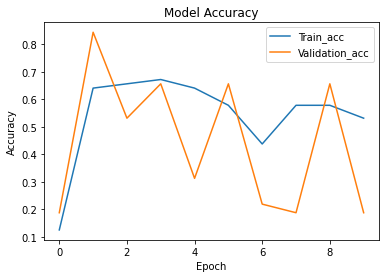

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Train_acc","Validation_acc"])
plt.show()

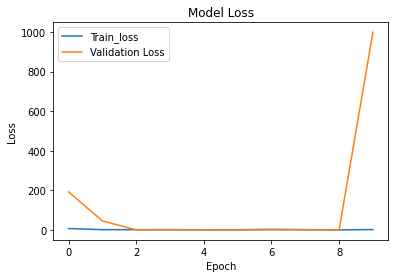

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Train_loss","Validation Loss"])
plt.show()

### Task 3: Model Evalution

In [18]:
preds = model.evaluate(test_generator)
print ("Evaluation Loss = " + str(preds[0]))
print ("Evaluation Accuracy = " + str(preds[1]))

41/41 [==============================] - 24s 578ms/step - loss: 810.7047 - accuracy: 0.2461
Evaluation Loss = 810.7046508789062
Evaluation Accuracy = 0.24611802399158478


### Task 4: ResNet50 Improved Version

### Task 4.1 : Data Retrieving and Preparing the Data

In [19]:
train_datagen = image.ImageDataGenerator(dtype = 'float32', 
                                         preprocessing_function=tf.keras.applications.resnet.preprocess_input, 
                                         validation_split=0.2)

test_datagen = image.ImageDataGenerator(dtype = 'float32', 
                                        preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    subset='training'
)

Found 4116 images belonging to 3 classes.


In [20]:
train_generator.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [21]:
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    subset='validation')

Found 1028 images belonging to 3 classes.


In [22]:
validation_generator.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [23]:
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical')

Found 1288 images belonging to 3 classes.


In [24]:
epochs = 10
stepsperepoch = 2
validationsteps=1

In [25]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=100)
mc = ModelCheckpoint("own.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [26]:
input_t = Input(shape=(224, 224, 3))

### Task 4.2 : Model Implementation

In [29]:
Conv_Base = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=3
)
for layer in Conv_Base.layers[:-8]:
    layer.trainable = False

model = Sequential()
model.add(Conv_Base)
model.add(Flatten())
model.add(Dense(units = 224, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 3, activation = 'softmax'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3)                 23593859  
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 224)               896       
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 675       
                                                                 
Total params: 23,595,430
Trainable params: 1,063,462
Non-trainable params: 22,531,968
_________________________________________________________________


In [31]:
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])

### Task 4.3 : Model Training and Results

In [32]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    callbacks=[annealer,mc,es],
    steps_per_epoch=stepsperepoch,
    validation_data=validation_generator,
    validation_steps = validationsteps
)

<ipython-input-32-3ac8fc2d45cc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 1.0968 - accuracy: 0.3438
Epoch 1: val_loss improved from inf to 1.07383, saving model to own.h5
2/2 [==============================] - 5s 2s/step - loss: 1.0968 - accuracy: 0.3438 - val_loss: 1.0738 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 1.0838 - accuracy: 0.5000
Epoch 2: val_loss did not improve from 1.07383
2/2 [==============================] - 2s 1s/step - loss: 1.0838 - accuracy: 0.5000 - val_loss: 1.0873 - val_accuracy: 0.5312 - lr: 9.5000e-04
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 1.0812 - accuracy: 0.4844
Epoch 3: val_loss improved from 1.07383 to 1.03701, saving model to own.h5
2/2 [==============================] - 2s 1s/step - loss: 1.0812 - accuracy: 0.4844 - val_loss: 1.0370 - val_accuracy: 0.7500 - lr: 9.0250e-04
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: 1.0632 - accuracy: 0.5625
Epoch 4: val_l

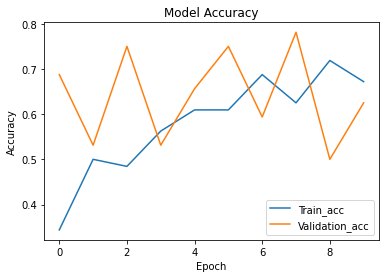

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Train_acc","Validation_acc"])
plt.show()

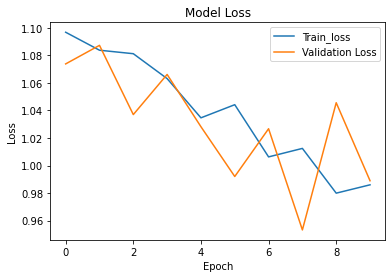

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Train_loss","Validation Loss"])
plt.show()

### Task 4.1 : Model Evalution

In [35]:
preds1 = model.evaluate(test_generator)
print ("Evaluation Loss = " + str(preds1[0]))
print ("Evaluation Accuracy = " + str(preds1[1]))

41/41 [==============================] - 15s 365ms/step - loss: 0.9748 - accuracy: 0.6638
Evaluation Loss = 0.9747965931892395
Evaluation Accuracy = 0.6638199090957642
